In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, ConstantKernel as C
from scipy.optimize import minimize
from scipy.stats.qmc import LatinHypercube
from scipy.stats import uniform, loguniform, norm
from sklearn.model_selection import RandomizedSearchCV
from mpl_toolkits.mplot3d import Axes3D
import itertools  # Import the itertools module


# Guide and Ideas for Capstone Project - Function 4

# Function 4: Fast, but Inaccurate Modelling
This example is for a particular business relying heavily on online sales. It can run very accurate calculations to figure out what is the optimal placement of their product across warehouses. Unfortunately, the calculations are extremely expensive (computationally) to run, so they can only do it once every two weeks. Instead, they propose using a machine learning model which approximates the solution quickly (in a few hours). The model has four hyper-parameters you need to tune, and the output corresponds to the difference between the expensive calculation, and the model. Since you are modelling a dynamical system, expect a lot of local optima!

We begin this guide by downloading the data:

In [2]:
X = np.load('initial_data/function_4/initial_inputs.npy')
Y = np.load('initial_data/function_4/initial_outputs.npy')
print(X)
print(Y)

[[0.89698105 0.72562797 0.17540431 0.70169437]
 [0.8893564  0.49958786 0.53926886 0.50878344]
 [0.25094624 0.03369313 0.14538002 0.49493242]
 [0.34696206 0.0062504  0.76056361 0.61302356]
 [0.12487118 0.12977019 0.38440048 0.2870761 ]
 [0.80130271 0.50023109 0.70664456 0.19510284]
 [0.24770826 0.06044543 0.04218635 0.44132425]
 [0.74670224 0.7570915  0.36935306 0.20656628]
 [0.40066503 0.07257425 0.88676825 0.24384229]
 [0.6260706  0.58675126 0.43880578 0.77885769]
 [0.95713529 0.59764438 0.76611385 0.77620991]
 [0.73281243 0.14524998 0.47681272 0.13336573]
 [0.65511548 0.07239183 0.68715175 0.08151656]
 [0.21973443 0.83203134 0.48286416 0.08256923]
 [0.48859419 0.2119651  0.93917791 0.37619173]
 [0.16713049 0.87655456 0.21723954 0.95980098]
 [0.21691119 0.16608583 0.24137226 0.77006248]
 [0.38748784 0.80453226 0.75179548 0.72382744]
 [0.98562189 0.66693268 0.15678328 0.8565348 ]
 [0.03782483 0.66485335 0.16198218 0.25392378]
 [0.68348638 0.9027701  0.33541983 0.99948256]
 [0.17034731 

In [3]:
def format_query(point, NoOfDigits):
    return '-'.join(f"{x:.{NoOfDigits}f}" for x in point)

In [4]:
# Print X with 16 digits of precision
for row in X:
    print(format_query(row,16))

# Print a separator line
print("-" * 50)

# Print Y with 16 digits of precision
print(format_query(Y,16))

0.8969810543559719-0.7256279703482243-0.1754043089024115-0.7016943693717497
0.8893563957199797-0.4995878553769650-0.5392688577643431-0.5087834390633533
0.2509462427523342-0.0336931305473536-0.1453800247355215-0.4949324205649785
0.3469620609143241-0.0062504002449179-0.7605636064368956-0.6130235572343078
0.1248711812207095-0.1297701930651067-0.3844004830013034-0.2870761010606128
0.8013027073487429-0.5002310937156627-0.7066445599562093-0.1951028410119162
0.2477082618994807-0.0604454273219898-0.0421863451371978-0.4413242505440316
0.7467022420948025-0.7570915044306501-0.3693530595537917-0.2065662810376639
0.4006650271944230-0.0725742510712734-0.8867682538447798-0.2438422897892272
0.6260705961944015-0.5867512592598441-0.4388057821707446-0.7788576937904925
0.9571352930644363-0.5976443830130996-0.7661138515714809-0.7762099053238541
0.7328124260168783-0.1452499789735880-0.4768127176311528-0.1333657340458458
0.6551154792459779-0.0723918269048233-0.6871517458198465-0.0815165641903302
0.2197344291

## Random Search

The simplest solution would be a simple random search, that is, we can randomly choose our next query point:

In [5]:
# Approach 1
next_query = np.random.uniform(size = 4)
print(next_query)

[0.38084852 0.07506516 0.59529722 0.63796756]


While this solution is easy to implement, we know it will be very slow. However, it could serve as a placeholder for gathering more information while you research which method you want to use for each function.

## Visualizing our data and thinking of the problem

Analysis of Initial Dataset: The initial dataset provided gives a starting point. Analyzing this data using statistical techniques or visualization might provide insights into the behavior of the functions and where to search next.

what we know about the problem:

1.From the hints, expect a lot of local optima.

In [6]:
# Convert to DataFrame for easier handling
df = pd.DataFrame(X, columns=['x1', 'x2', 'x3', 'x4'])
df['output'] = Y

In [7]:
# Statistical Summary
print("Statistical Summary:")
print(df.describe())


Statistical Summary:
              x1         x2         x3         x4     output
count  30.000000  30.000000  30.000000  30.000000  30.000000
mean    0.542872   0.477129   0.465693   0.474096 -17.238587
std     0.294007   0.308910   0.261618   0.292412   7.137959
min     0.037825   0.006250   0.042186   0.081517 -32.625660
25%     0.258744   0.150459   0.223273   0.215885 -21.578590
50%     0.601918   0.499909   0.445999   0.499451 -16.040082
75%     0.787653   0.749126   0.708686   0.758504 -12.745906
max     0.985622   0.919592   0.939178   0.999483  -4.025542


[0.36773878 0.63021641 0.73166579 0.5794345  0.78866901 0.5992485
 0.69733892 0.58039133 0.54462802 0.69523819 0.18563783 0.66775988
 0.5575692  0.56358165 0.51774825 0.21202148 0.69465923 0.46098071
 0.13015284 0.6616376  0.11183761 0.73635774 0.20167308 0.86219522
 0.90641483 0.         0.44182203 1.         0.681916   0.33168506]


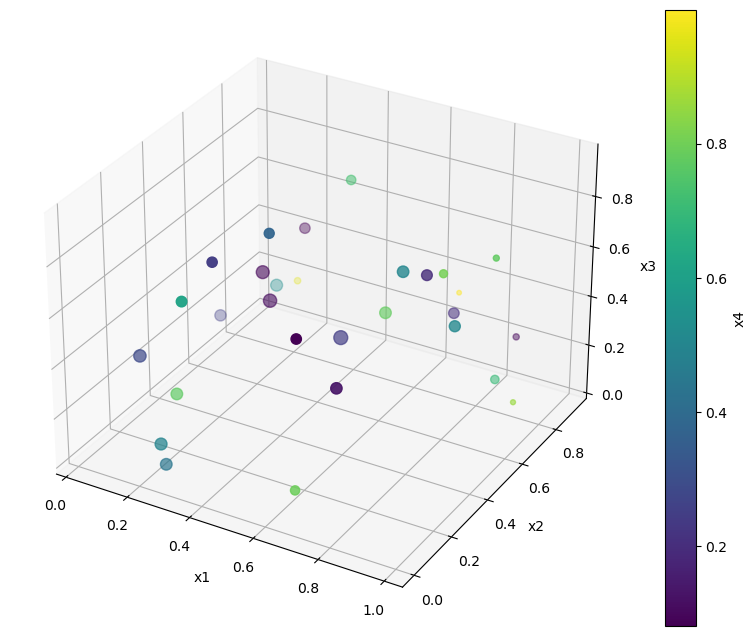

In [8]:
# Normalize Y for better visualization
Y_norm = (Y - Y.min()) / (Y.max() - Y.min())
print(Y_norm)

# Size scaling factor - you can adjust this
size_scale = 100 

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Use color for the fourth dimension and size for the fifth dimension
sc = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=X[:, 3], cmap='viridis', s=Y_norm * size_scale)

# Create colorbar
cbar = plt.colorbar(sc)
cbar.set_label('x4')

# Set labels for axes
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')

# Show plot
plt.show()

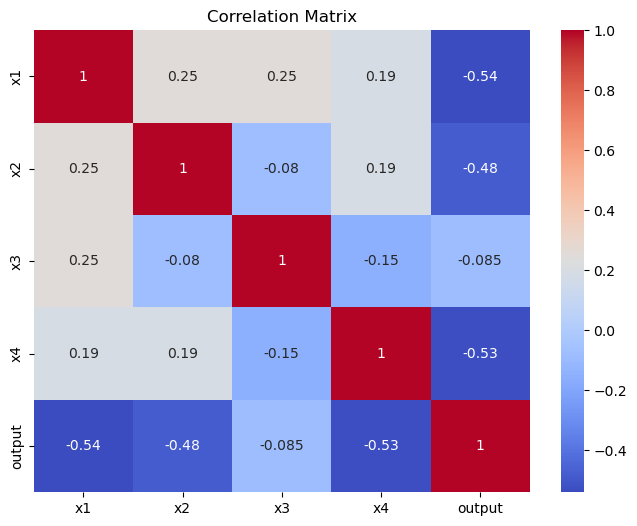

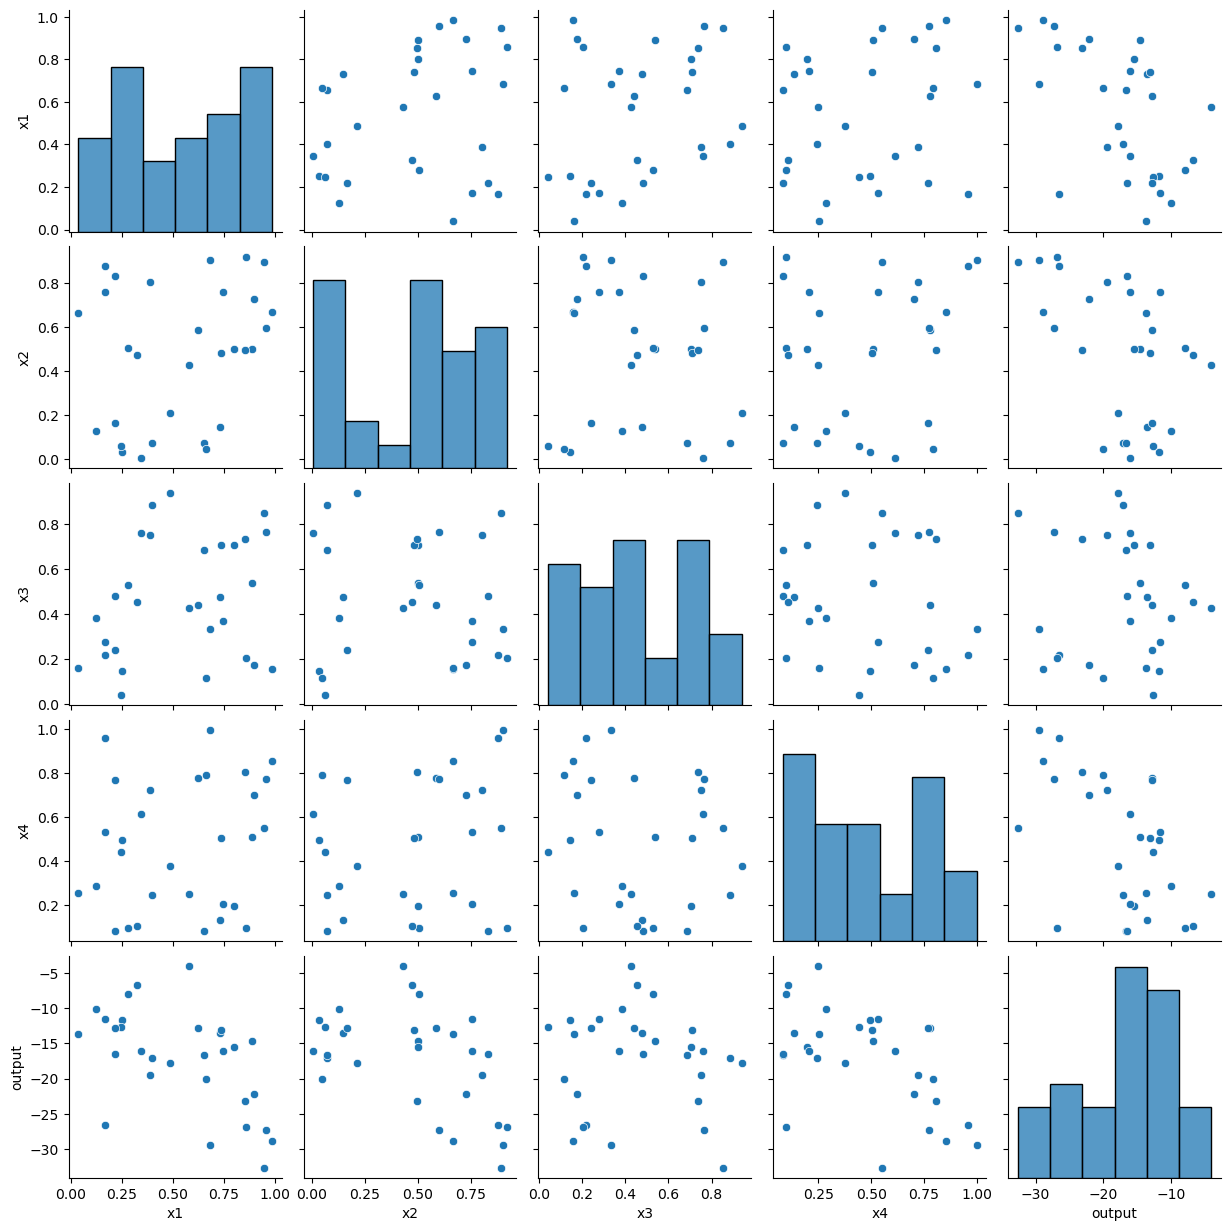

In [9]:
# Calculate correlations
correlations = df.corr()

# Plotting the correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Pairplot to visualize relationships
sns.pairplot(df)
plt.show()

In [1]:
#Approach 2: using Randomized Hyperparameter Search for a Gaussian Process Regressor 
# and the implementation of several acquisition functions commonly used in Bayesian optimization: Expected Improvement (EI), Probability of Improvement (PI), and Upper Confidence Bound (UCB).
# and random search within a specified range

#Randomized Hyperparameter Search: 
#defines a search space for the kernel parameters, creates a Gaussian process model, and then uses RandomizedSearchCV to find the best hyperparameters based on cross-validation. 
# The best model and parameters are then displayed.
param_distributions = {
    'kernel__k1__constant_value': loguniform(1e-3, 1e3), #  the vertical scale of your function.
    'kernel__k2__length_scale': loguniform(1e-2, 1e2), # in the Radial-basis Function (RBF) kernel (also known as the Gaussian kernel) controls the horizontal length scale, i.e., how smooth or wiggly the function is.
    'alpha': loguniform(1e-10, 1e-2) # represents the noise level in the target variable. can help the model to account for noise in the observations.
}

# Define the kernel with initial parameters
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))  

# Create a Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20) # ontrols how many times the optimizer restarts, which is important for avoiding local optima in complex, multi-modal landscapes.

random_search = RandomizedSearchCV(gp, param_distributions, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X,Y)

best_gp = random_search.best_estimator_
best_params = random_search.best_params_
print("Best Parameters:", best_params)
print(f"Log-marginal-likelihood: {best_gp.log_marginal_likelihood(best_gp.kernel_.theta)}")

#an acquisition function used in Bayesian optimization. 
# The EI is calculated for a set of points X, given a Gaussian process gp. It's used to determine the next point to sample.

def expected_improvement(X, gp, xi=0.01):
    
    mu, sigma = gp.predict(X, return_std=True)
    mu_sample_opt = np.max(gp.predict(gp.X_train_)) # Finds the best (maximum) output observed so far from the training data of the Gaussian process.

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi # represents the improvement over mu_sample_opt that is expected for each point in X, adjusted by the trade-off parameter xi.
        Z = imp / sigma #is a standardized version of imp, which is used to calculate the probability and density values from the normal distribution.
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z) # Computes the expected improvement for each point in X, which includes both the expected improvement (imp) and the uncertainty (sigma) at that point.
        ei[sigma == 0.0] = 0.0

    return ei.flatten()

# Probability of Improvement acquisition function
def probability_of_improvement(X, gp, xi=0.01):
    
    mu, sigma = gp.predict(X, return_std=True)
    mu_sample_opt = np.max(gp.predict(gp.X_train_))
    
    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        pi = norm.cdf(Z)
        pi[sigma == 0.0] = 0.0
    
    return pi.flatten()

# Define the UCB acquisition function
# After optimizing the hyperparameters, the Upper Confidence Bound (UCB) is used as the acquisition function in the weekly optimization loop. 
# The UCB balances exploration (trying new, uncertain points) and exploitation (focusing on points known to yield good results).
def upper_confidence_bound(X, gpr, kappa=1.96):
    
    mu, sigma = gpr.predict(X, return_std=True)
    return mu + kappa * sigma

def generate_nd_grid(max_points, dimensions):
    # define range for input
	r_min, r_max = 0, 1.0

	# generate a random sample from the domain (dimensions)
	nd_grid = r_min + np.random.rand(max_points, dimensions) * (r_max - r_min)
	
	return np.array(nd_grid)

# Kappa parameters for exploration-exploitation balance
#As the loop progresses, kappa decreases, gradually shifting the focus from exploring uncertain regions to exploiting regions known to yield better results.
kappa_initial = 1.96
kappa_decay = 0.9
min_kappa = 0.1
# Define xi parameters for exploration-exploitation balance
xi_initial = 0.1
xi_decay = 0.9
min_xi = 0.01


# generate grid
max_points = 7000000 #9,000,000 (too big for memory)
dimensions = 4  # Change this to the desired number of dimensions
X_grid = []
X_grid = generate_nd_grid(max_points, dimensions)


# Define the number of weeks you plan to run this optimization
N_WEEKS = 10  # adjust this based on your requirement
# Weekly Optimization Loop
for week in range(N_WEEKS):
    # Decay kappa value exponentially for exploration-exploitation balance
    kappa = max(kappa_initial * (kappa_decay ** week), min_kappa)
    xi = max(xi_initial * (xi_decay ** week), min_xi)
    print(f"Week {week + 1}, kappa: {kappa}, xi: {xi}")

# EI next point calcuation
ei_values = expected_improvement(X_grid, best_gp,xi) # presumably the best Gaussian process model found via hyperparameter tuning (e.g., using RandomizedSearchCV)
next_point_index_ei = np.argmax(ei_values) # Finds the index of the maximum expected improvement in the grid.
next_point_ei = X_grid[next_point_index_ei] #considered the best candidate for the next function evaluation as it is expected to yield the most information gain according to the EI criterion.
print('Next query EI: ', format_query(next_point_ei,6))

# PI next point calcuation
pi_values = probability_of_improvement(X_grid, best_gp,xi)
# Select the point with the highest Probability of Improvement
next_point_index_pi = np.argmax(pi_values)
next_point_pi = X_grid[next_point_index_pi]
# Format the query point for printing, assuming the existence of a function 'format_query'
print('Next query PI: ', format_query(next_point_pi, 6))

# Select the point based on UCB using updated kappa
"""
Week 1, kappa: 1.96, xi: 0.1
Week 2, kappa: 1.764, xi: 0.09000000000000001
Week 3, kappa: 1.5876000000000001, xi: 0.08100000000000002
Week 4, kappa: 1.42884, xi: 0.0729
Week 5, kappa: 1.285956, xi: 0.06561
Week 6, kappa: 1.1573604000000002, xi: 0.05904900000000001
Week 7, kappa: 1.0416243600000001, xi: 0.05314410000000001
Week 8, kappa: 0.9374619240000002, xi: 0.04782969000000001
Week 9, kappa: 0.8437157316000001, xi: 0.04304672100000001
Week 10, kappa: 0.7593441584400001, xi: 0.03874204890000001
"""
ucb_value = upper_confidence_bound(X_grid, best_gp, kappa)
# Select the point with the highest UCB
next_point_index_ucb = np.argmax(ucb_value)
next_point_ucb = X_grid[next_point_index_ucb]
# Format the query point for printing, assuming the existence of a function 'format_query'
print('Next query UCB: ', format_query(next_point_ucb, 6))

NameError: name 'np' is not defined

In [16]:
#Approach 2

#Randomized Hyperparameter Search: 
#defines a search space for the kernel parameters, creates a Gaussian process model, and then uses RandomizedSearchCV to find the best hyperparameters based on cross-validation. 
# The best model and parameters are then displayed.
param_distributions = {
    'kernel__k1__constant_value': loguniform(1e-3, 1e3), #  the vertical scale of your function.
    'kernel__k2__length_scale': loguniform(1e-2, 1e2), # in the Radial-basis Function (RBF) kernel (also known as the Gaussian kernel) controls the horizontal length scale, i.e., how smooth or wiggly the function is.
    'alpha': loguniform(1e-10, 1e-2) # represents the noise level in the target variable. can help the model to account for noise in the observations.
}

# Define the kernel with initial parameters
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))  

# Create a Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20) # ontrols how many times the optimizer restarts, which is important for avoiding local optima in complex, multi-modal landscapes.

random_search = RandomizedSearchCV(gp, param_distributions, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X,Y)

best_gp = random_search.best_estimator_
best_params = random_search.best_params_
print("Best Parameters:", best_params)
print(f"Log-marginal-likelihood: {best_gp.log_marginal_likelihood(best_gp.kernel_.theta)}")

#an acquisition function used in Bayesian optimization. 
# The EI is calculated for a set of points X, given a Gaussian process gp. It's used to determine the next point to sample.

def expected_improvement(X, gp, xi=0.01):

    mu, sigma = gp.predict(X, return_std=True)
    mu_sample_opt = np.max(gp.predict(gp.X_train_)) # Finds the best (maximum) output observed so far from the training data of the Gaussian process.

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi # represents the improvement over mu_sample_opt that is expected for each point in X, adjusted by the trade-off parameter xi.
        Z = imp / sigma #is a standardized version of imp, which is used to calculate the probability and density values from the normal distribution.
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z) # Computes the expected improvement for each point in X, which includes both the expected improvement (imp) and the uncertainty (sigma) at that point.
        ei[sigma == 0.0] = 0.0

    return ei.flatten()

# Probability of Improvement acquisition function
def probability_of_improvement(X, gp, xi=0.01):

    mu, sigma = gp.predict(X, return_std=True)
    mu_sample_opt = np.max(gp.predict(gp.X_train_))
    
    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        pi = norm.cdf(Z)
        pi[sigma == 0.0] = 0.0
    
    return pi.flatten()

# Define the UCB acquisition function
# After optimizing the hyperparameters, the Upper Confidence Bound (UCB) is used as the acquisition function in the weekly optimization loop. 
# The UCB balances exploration (trying new, uncertain points) and exploitation (focusing on points known to yield good results).
def upper_confidence_bound(X, gpr, kappa=1.96):

    mu, sigma = gpr.predict(X, return_std=True)
    return mu + kappa * sigma

def generate_nd_grid(max_points, dimensions):
    # Calculate the number of grid points along each dimension
    dim = int(max_points ** (1 / dimensions))

    # Create a list of linspace arrays for each dimension
    linspace_arrays = [np.linspace(0, 1, dim) for _ in range(dimensions)]

    # Create the n-dimensional grid using itertools.product
    nd_grid = list(itertools.product(*linspace_arrays))

    return np.array(nd_grid)

# Kappa parameters for exploration-exploitation balance
#As the loop progresses, kappa decreases, gradually shifting the focus from exploring uncertain regions to exploiting regions known to yield better results.
kappa_initial = 1.96
kappa_decay = 0.9
min_kappa = 0.1
# Define xi parameters for exploration-exploitation balance
xi_initial = 0.1
xi_decay = 0.9
min_xi = 0.01


# Example usage:
max_points = 100000
dimensions = 4  # Change this to the desired number of dimensions
X_grid = []
X_grid = generate_nd_grid(max_points, dimensions)


# Define the number of weeks you plan to run this optimization
N_WEEKS = 10  # adjust this based on your requirement
# Weekly Optimization Loop
for week in range(N_WEEKS):
    # Decay kappa value exponentially for exploration-exploitation balance
    kappa = max(kappa_initial * (kappa_decay ** week), min_kappa)
    xi = max(xi_initial * (xi_decay ** week), min_xi)
    print(f"Week {week + 1}, kappa: {kappa}, xi: {xi}")

# EI next point calcuation
ei_values = expected_improvement(X_grid, best_gp,xi) # presumably the best Gaussian process model found via hyperparameter tuning (e.g., using RandomizedSearchCV)
next_point_index_ei = np.argmax(ei_values) # Finds the index of the maximum expected improvement in the grid.
next_point_ei = X_grid[next_point_index_ei] #considered the best candidate for the next function evaluation as it is expected to yield the most information gain according to the EI criterion.
print('Next query EI: ', format_query(next_point_ei,6))

# PI next point calcuation
pi_values = probability_of_improvement(X_grid, best_gp,xi)
# Select the point with the highest Probability of Improvement
next_point_index_pi = np.argmax(pi_values)
next_point_pi = X_grid[next_point_index_pi]
# Format the query point for printing, assuming the existence of a function 'format_query'
print('Next query PI: ', format_query(next_point_pi, 6))

# Select the point based on UCB using updated kappa
"""
Week 1, kappa: 1.96, xi: 0.1
Week 2, kappa: 1.764, xi: 0.09000000000000001
Week 3, kappa: 1.5876000000000001, xi: 0.08100000000000002
Week 4, kappa: 1.42884, xi: 0.0729
Week 5, kappa: 1.285956, xi: 0.06561
Week 6, kappa: 1.1573604000000002, xi: 0.05904900000000001
Week 7, kappa: 1.0416243600000001, xi: 0.05314410000000001
Week 8, kappa: 0.9374619240000002, xi: 0.04782969000000001
Week 9, kappa: 0.8437157316000001, xi: 0.04304672100000001
Week 10, kappa: 0.7593441584400001, xi: 0.03874204890000001
"""
ucb_value = upper_confidence_bound(X_grid, best_gp, kappa)
# Select the point with the highest UCB
next_point_index_ucb = np.argmax(ucb_value)
next_point_ucb = X_grid[next_point_index_ucb]
# Format the query point for printing, assuming the existence of a function 'format_query'
print('Next query UCB: ', format_query(next_point_ucb, 6))

Best Parameters: {'alpha': 0.0004566054873446117, 'kernel__k1__constant_value': 0.018794668241638453, 'kernel__k2__length_scale': 0.05337032762603955}
Log-marginal-likelihood: -83.97588004771474
Week 1, kappa: 1.96, xi: 0.1
Week 2, kappa: 1.764, xi: 0.09000000000000001
Week 3, kappa: 1.5876000000000001, xi: 0.08100000000000002
Week 4, kappa: 1.42884, xi: 0.0729
Week 5, kappa: 1.285956, xi: 0.06561
Week 6, kappa: 1.1573604000000002, xi: 0.05904900000000001
Week 7, kappa: 1.0416243600000001, xi: 0.05314410000000001
Week 8, kappa: 0.9374619240000002, xi: 0.04782969000000001
Week 9, kappa: 0.8437157316000001, xi: 0.04304672100000001
Week 10, kappa: 0.7593441584400001, xi: 0.03874204890000001
Next query EI:  0.437500-0.375000-0.375000-0.437500
Next query PI:  0.500000-0.375000-0.375000-0.312500
Next query UCB:  0.437500-0.375000-0.375000-0.437500


In [ ]:
#Gaussian Process Regression with Noise Term in Kernel
# Example: Using a Gaussian Process with an RBF kernel
kernel = Matern(nu=2.5)
gpr = GaussianProcessRegressor(kernel=kernel)

# Training the GP on initial data
# X_train and y_train should be your initial training data
gpr.fit(X, Y)

In [ ]:
#Acquisition Function for Exploration-Exploitation Trade-off

# Define the Upper Confidence Bound (UCB) acquisition function
def upper_confidence_bound(gp, x, kappa=1.96):
    x = np.atleast_2d(x)
    mean, std = gp.predict(x, return_std=True)
    return mean - kappa * std  # Minus because we want to minimize the adverse reaction

# Define the Expected Improvement (EI) acquisition function
def expected_improvement(gp, x, xi=0.01):
    x = np.atleast_2d(x)
    mu, sigma = gp.predict(x, return_std=True)
    mu_sample_opt = np.max(gp.predict(gp.X_train_))

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

bounds = [(0, 1), (0, 1), (0, 1), (0, 1)]  # Assuming each compound can vary between 0 and 1

def propose_next_point(acquisition_func, gp, bounds):
    n_restarts = 10
    best_value = float('inf')
    best_x = None
    
    for starting_point in np.random.uniform(0, 1, size=(n_restarts, len(bounds))):
        res = minimize(lambda x: -acquisition_func(gp, x), 
                       x0=starting_point, 
                       bounds=bounds)
        if res.fun < best_value:
            best_value = res.fun
            best_x = res.x
            
    return best_x

# Propose the next point to sample
next_point = propose_next_point(upper_confidence_bound, gpr, bounds)
print("Next point to sample:", format_query(next_point,6))

In [ ]:
#Hyperparameter Tuning for the Machine Learning Model
# We'll use a Random Search approach, which is often more efficient than Grid Search and can be implemented using Scikit-Learn.

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# RandomForestRegressor
model = RandomForestRegressor()

# Define the hyperparameter space to search
param_distributions = {
    'n_estimators': [10, 50, 100, 200],
    'max_features': [None, 'sqrt', 'log2'],  # Remove 'auto'
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Setup the random search with cross-validation
random_search = RandomizedSearchCV(model, param_distributions, n_iter=50, cv=5, verbose=1, random_state=42)

# Reshape y_train to be a 1D array
y_train_reshaped = Y.ravel()

# Fit the model
random_search.fit(X, y_train_reshaped)

# Best parameters
print("Best Parameters:", random_search.best_params_)

In [ ]:
# Configure the model with the best parameters
rf_best_model = RandomForestRegressor(n_estimators=50,
                                   min_samples_split=5,
                                   min_samples_leaf=1,
                                   max_features='log2',
                                   max_depth=10)

# Train the model with the best parameters on the full training data
rf_best_model.fit(X, Y.ravel())

# Your model is now ready to be used for predictions or further evaluation

In [ ]:
def surrogate_objective_function(x):
    return rf_best_model.predict([x])[0]

In [ ]:
from scipy.optimize import basinhopping

# Initial guess for hyperparameters
x0 = [0.523717, 0.475768, 0.401608, 0.364610]

# Set up the optimizer with the surrogate objective function
minimizer_kwargs = {"method": "BFGS"}
result = basinhopping(surrogate_objective_function, x0, minimizer_kwargs=minimizer_kwargs, niter=100)

# Result
print("Optimized hyperparameters: x = {}, surrogate output = {}".format(result.x, result.fun))
